# Random Effects Neural Networks with Edward and Keras
Bayesian probabilistic models provide a nimble and expressive framework for modeling "small-world" data. In contrast, deep learning offers a more rigid yet much more powerful framework for modeling data of massive size. [Edward](http://edwardlib.org/) is a probabilistic programming library that bridges this gap: "black-box" variational inference enables us to fit extremely flexible Bayesian models to large-scale data. Furthermore, these models themselves may take advantage of classic deep-learning architectures of arbitrary complexity.

Edward uses [TensorFlow](https://www.tensorflow.org/) for symbolic gradients and data flow graphs. As such, it interfaces cleanly with other libraries that do the same, namely [TF-Slim](https://research.googleblog.com/2016/08/tf-slim-high-level-library-to-define.html), [PrettyTensor](https://github.com/google/prettytensor) and [Keras](https://keras.io/). Personally, I've been working often with the latter, and am consistently delighted by the ease with which it allows me to specify complex neural architectures.

The aim of this work is to lay a practical foundation for Bayesian modeling in Edward, then explore how, and how easily, we can extend these models in the direction of classical deep learning via Keras. It will give both a conceptual overview of the models below, as well as notes on the practical considerations of their implementation —  what worked and what didn't. Finally, this work will conclude with concrete ways in which to extend these models further, of which there are many.

If you're just getting started with Edward or Keras, I recommend first perusing the [Edward tutorials](http://edwardlib.org/tutorials) and [Keras documentation](https://keras.io/) respectively.

To "pull us down the path," we build three models in additive fashion: a Bayesian linear regression model, a Bayesian linear regression model with random effects, and a neural network with random effects. We fit them on the [Zillow Prize](https://www.kaggle.com/c/zillow-prize-1) dataset, which asks us to predict `logerror` (in house-price estimate, i.e. the "Zestimate") given metadata for a list of homes. These models are intended to be demonstrative, not performant: they will not win you the prize in their current form. 

In [ ]:
## note from http://willwolf.io/2017/06/15/random-effects-neural-networks/

In [1]:
import tensorflow as tf 
print(tf.__version__)

1.2.0


In [2]:
import edward as ed
from edward.models import Normal
from keras.layers import Input, Dense
from keras.regularizers import l2
from keras import backend as K
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
# ensure you are using TensorFlow as your Keras backend
sess = ed.get_session()
K.set_session(sess)

INIT_OP = tf.global_variables_initializer()

## Data preparation
After importing the data we rename its columns as per Philipp Spachtholz's [Exploratory Analysis - Zillow](https://www.kaggle.com/philippsp/exploratory-analysis-zillow) kernel on [kaggle.com](https://www.kaggle.com).

In [6]:
!ls ../Data/

properties_2016.csv	   train_2016_v2.csv
properties_2016.csv.zip    train_2016_v2.csv.zip
sample_submission.csv	   zillow_data_dictionary.xlsx
sample_submission.csv.zip  zillow_data_dictionary.xlsx.zip


In [7]:
properties_df = pd.read_csv('../Data/properties_2016.csv', low_memory=False)
transactions_df = pd.read_csv('../Data/train_2016_v2.csv')

In [8]:
properties_df = properties_df.rename(columns={
    'parcelid': 'id_parcel',
    'yearbuilt': 'build_year',
    'basementsqft': 'area_basement',
    'yardbuildingsqft17': 'area_patio',
    'yardbuildingsqft26': 'area_shed',
    'poolsizesum': 'area_pool',
    'lotsizesquarefeet': 'area_lot',
    'garagetotalsqft': 'area_garage',
    'finishedfloor1squarefeet': 'area_firstfloor_finished',
    'calculatedfinishedsquarefeet': 'area_total_calc',
    'finishedsquarefeet6': 'area_base',
    'finishedsquarefeet12': 'area_live_finished',
    'finishedsquarefeet13': 'area_liveperi_finished',
    'finishedsquarefeet15': 'area_total_finished',
    'finishedsquarefeet50': 'area_unknown',
    'unitcnt': 'num_unit',
    'numberofstories': 'num_story',
    'roomcnt': 'num_room',
    'bathroomcnt': 'num_bathroom',
    'bedroomcnt': 'num_bedroom',
    'calculatedbathnbr': 'num_bathroom_calc',
    'fullbathcnt': 'num_bath',
    'threequarterbathnbr': 'num_75_bath',
    'fireplacecnt': 'num_fireplace',
    'poolcnt': 'num_pool',
    'garagecarcnt': 'num_garage',
    'regionidcounty': 'region_county',
    'regionidcity': 'region_city',
    'regionidzip': 'region_zip',
    'regionidneighborhood': 'region_neighbor',
    'taxvaluedollarcnt': 'tax_total',
    'structuretaxvaluedollarcnt': 'tax_building',
    'landtaxvaluedollarcnt': 'tax_land',
    'taxamount': 'tax_property',
    'assessmentyear': 'tax_year',
    'taxdelinquencyflag': 'tax_delinquency',
    'taxdelinquencyyear': 'tax_delinquency_year',
    'propertyzoningdesc': 'zoning_property',
    'propertylandusetypeid': 'zoning_landuse',
    'propertycountylandusecode': 'zoning_landuse_county',
    'fireplaceflag': 'flag_fireplace',
    'hashottuborspa': 'flag_tub',
    'buildingqualitytypeid': 'quality',
    'buildingclasstypeid': 'framing',
    'typeconstructiontypeid': 'material',
    'decktypeid': 'deck',
    'storytypeid': 'story',
    'heatingorsystemtypeid': 'heating',
    'airconditioningtypeid': 'aircon',
    'architecturalstyletypeid': 'architectural_style'
})

transactions_df = transactions_df.rename(columns={
  'parcelid': 'id_parcel',
  'transactiondate': 'date'
})

### Build training DataFrame

In [9]:
data = transactions_df.merge(properties_df, how='left', left_on='id_parcel', right_on='id_parcel')

### Drop columns containing too many nulls
Bayesian probabilistic models allow us to flexibly model *missing* data itself. To this end, we conceive of a given predictor as a vector of both:
1. Observed values.
2. Parameters in place of missing values, which will form a posterior distribution for what this value might have been.
    
In a (partially-specified, for brevity) linear model, this might look as follows:

$$
y_i \sim \mathcal{N}(\mu_i, \sigma)\\
\mu_i = \alpha + \beta_N N_i\\
N_i \sim \mathcal{N}(\nu, \sigma_N)\\
$$

where $N_i$ is our sometimes-missing predictor. When $N_i$ is observed, $\mathcal{N}(\nu, \sigma_N)$ serves as a likelihood: given this data-point, we tweak retrodictive distributions on the parameters $(\nu, \sigma_N)$ by which it was produced. Conversely, when $N_i$ is missing it serves as a prior: after learning distributions of $(\nu, \sigma_N)$ we can generate a likely value of $N_i$ itself. Finally, inference will give us (presumably-wide) distributions on the model's belief in what was the true value of each missing $N_i$ conditional on the data observed.

I tried this in Edward, albeit briefly, to no avail. Dustin Tran gives an [example](https://discourse.edwardlib.org/t/how-to-handle-missing-values-in-gaussian-matrix-factorization/95/2) of how one might accomplish this task in the case of Gaussian Matrix Factorization. In my case, I wasn't able to apply a 2-D missing-data-mask placeholder to a 2-D data placeholder via [`tf.gather`](https://www.tensorflow.org/api_docs/python/tf/gather) nor [`tf.gather_nd`](https://www.tensorflow.org/api_docs/python/tf/gather_nd). With more effort, I'm sure I could make this work. Help appreciated.

For now, we'll first drop columns containing too many null values, then, after choosing a few of the predictors most correlated with the target, drop the remaining rows containing nulls.

In [10]:
keep_cols = data.columns[ data.isnull().mean() < .25 ]
data = data[keep_cols]

### Which columns are most correlated with the target?

In [11]:
float_cols = [col for col in data.columns if data[col].dtype == np.float64]

data[float_cols]\
    .corr()['logerror']\
    .abs()\
    .sort_values(ascending=False)\
    .head(10)

logerror               1.000000
area_live_finished     0.041922
area_total_calc        0.038784
num_bathroom_calc      0.029448
num_bath               0.028845
num_bathroom           0.027889
num_bedroom            0.025467
tax_building           0.022085
build_year             0.017312
censustractandblock    0.008892
Name: logerror, dtype: float64

### Drop rows with null values

In [12]:
data.dropna(inplace=True)
data.reset_index(inplace=True)

### Select three fixed-effect predictors

In [13]:
fixed_effect_predictors = [
    'area_live_finished', 
    'num_bathroom', 
    'build_year'
]

### Select one random-effect predictor

In [14]:
zip_codes = data['region_zip'].astype('category').cat.codes

### Split data into train, validation sets

In [15]:
train_index = data.sample(frac=0.5).index
val_index = data.drop(train_index).index

X = data.drop('logerror', axis=1)[fixed_effect_predictors]
X = scale(X)
y = data['logerror'].values

X_train = X[train_index]
y_train = y[train_index]
X_val = X[val_index]
y_val = y[val_index]

print('Dataset sizes:')
print(f'    X_train:  {X_train.shape}')
print(f'    X_val:    {X_val.shape}')
print(f'    y_train:  {y_train.shape}')
print(f'    y_val:    {y_val.shape}')

Dataset sizes:
    X_train:  (36986, 3)
    X_val:    (36986, 3)
    y_train:  (36986,)
    y_val:    (36986,)


# Bayesian linear regression
Using three fixed-effect predictors we'll fit a model of the following form:

$$
y_i \sim \mathcal{N}(\mu_i, 1)\\
\mu_i = \alpha + \beta x_i\\
\alpha \sim \mathcal{N}(0, 1)\\
\beta \sim \mathcal{N}(0, 1)\\
$$

Having normalized our data to have mean 0 and unit-variance, we place our priors on a similar scale.

To infer posterior distributions of the model's parameters conditional on the data observed we employ variational inference — one of three inference classes supported in Edward. This approach posits posterior inference as posterior *approximation* via *optimization*, where optimization is done via stochastic, gradient-based methods. This is what enables us to scale complex probabilistic functional forms to large-scale data.

For an introduction to variational inference and Edward's API thereof, please reference:
- [Edward: Inference of Probabilistic Models](http://edwardlib.org/tutorials/inference)
- [Edward: Variational Inference](http://edwardlib.org/tutorials/variational-inference)
- [Edward: KL(q||p) Minimization](http://edwardlib.org/tutorials/klqp)
- [Edward: API and Documentation - Inference](http://edwardlib.org/api/inference)

Additionally, I provide an introduction to the basic math behind variational inference and the [ELBO](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf) in a blog post of mine: [Further Exploring Common Probabilistic Models](http://willwolf.io/2017/07/06/further-exploring-common-probabilistic-models/).

### Fit model
For the approximate q-distributions, we apply the [softplus function](https://www.tensorflow.org/api_docs/python/tf/nn/softplus) — `log(exp(z) + 1)` — to the scale parameter values at the suggestion of the Edward docs.

In [16]:
N, D = X_train.shape

# fixed-effects placeholders
fixed_effects = tf.placeholder(tf.float32, [N, D])

# fixed-effects parameters
β_fixed_effects = Normal(loc=tf.zeros(D), scale=tf.ones(D))
α = Normal(loc=tf.zeros(1), scale=tf.ones(1))

# model
μ_y = α + ed.dot(fixed_effects, β_fixed_effects)
y = Normal(loc=μ_y, scale=tf.ones(N))

# approximate fixed-effects distributions 
qβ_fixed_effects = Normal(
    loc=tf.Variable(tf.random_normal([D])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([D])))
)
qα = Normal(
    loc=tf.Variable(tf.random_normal([1])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([1])))
)

### Infer parameters

In [17]:
latent_vars = {
    β_fixed_effects: qβ_fixed_effects,
    α: qα
}

sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={fixed_effects: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 34670.074


### Criticize model

In [18]:
def visualize_data_fit(X, y, β, α, title_prefix, n_samples=10):
    '''Plot lines generated via samples from parameter distributions of the first 
    two fixed effects, vs. observed data points.
    Args:
        X (np.array) : A design matrix of observed fixed effects.
        y (np.array) : A vector of observed responses.
        β (ed.RandomVariable) : A multivariate distribution of fixed-effect parameters.
        α (ed.RandomVariable) : A univariate distribution of the model's intercept term.
        title_prefix (str) : A string to append to the beginning of the title.
        n_samples (int) : The number of lines to plot as drawn from the parameter distributions.
    '''
    
    # draw samples from parameter distributions
    β_samples = β.sample(n_samples).eval()
    α_samples = α.sample(n_samples).eval()
    
    # plot the first two dimensions of `X`, vs. `y`
    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection='3d')
    ax.scatter(X[:, 0], X[:, 1], y)
    plt.title(f'{title_prefix} Parameter Samples vs. Observed Data')
    
    # plot lines defined by parameter samples
    inputs = np.linspace(-10, 10, num=500)
    for i in range(n_samples):
        output = inputs * β_samples[i][0] + inputs * β_samples[i][1] + α_samples[i][0]
        ax.plot(inputs, inputs, output)

#### Visualize data fit given parameter priors

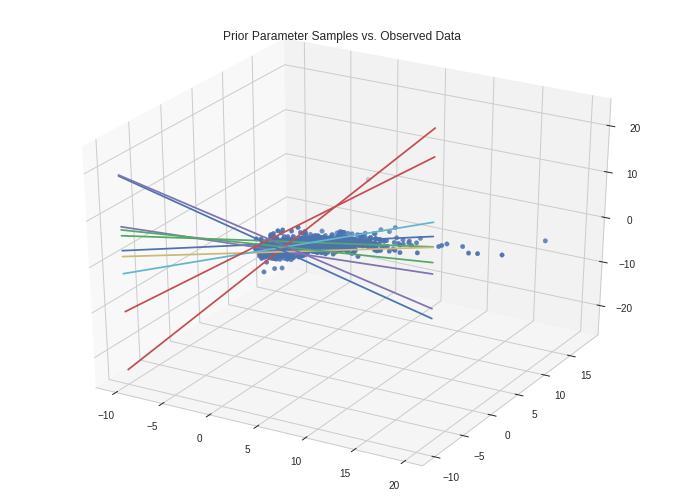

In [19]:
visualize_data_fit(X_train, y_train, β_fixed_effects, α, 'Prior', n_samples=10)

#### Visualize data fit given parameter posteriors

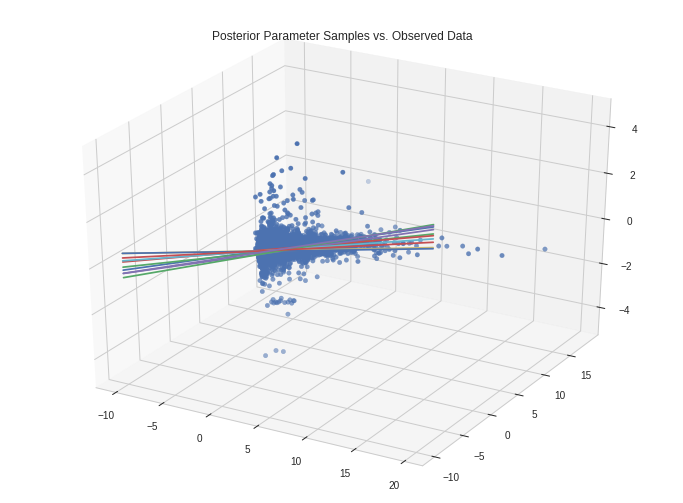

In [20]:
visualize_data_fit(X_train, y_train, qβ_fixed_effects, qα, 'Posterior', n_samples=10)

It appears as if our model fits the data along the first two dimensions. This said, we could improve this fit considerably. This will become apparent when we compute the MAE on our validation set.

#### Inspect residuals

In [21]:
def compute_mean_absolute_error(y_posterior, X_val_feed_dict, y_val=y_val):
    data = {y_posterior: y_val}
    data.update(X_val_feed_dict)
    mae = ed.evaluate('mean_absolute_error', data=data)
    print(f'Mean absolute error on validation data: {mae:1.5}')
    
def plot_residuals(y_posterior, X_val_feed_dict, title, y_val=y_val):
    y_posterior_preds = y_posterior.eval(feed_dict=X_val_feed_dict)
    plt.figure(figsize=(9, 6))
    plt.hist(y_posterior_preds - y_val, edgecolor='white', linewidth=1, bins=30, alpha=.7)
    plt.axvline(0, color='#A60628', linestyle='--')
    plt.xlabel('`y_posterior_preds - y_val`', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title(title, fontsize=16)

In [22]:
param_posteriors = {
    β_fixed_effects: qβ_fixed_effects.mean(),
    α: qα.mean()
}
X_val_feed_dict = {
    fixed_effects: X_val
}
y_posterior = ed.copy(y, param_posteriors)

In [23]:
print(f'Mean validation `logerror`: {y_val.mean()}')
compute_mean_absolute_error(y_posterior, X_val_feed_dict)

Mean validation `logerror`: 0.01235439355431785
Mean absolute error on validation data: 0.087188


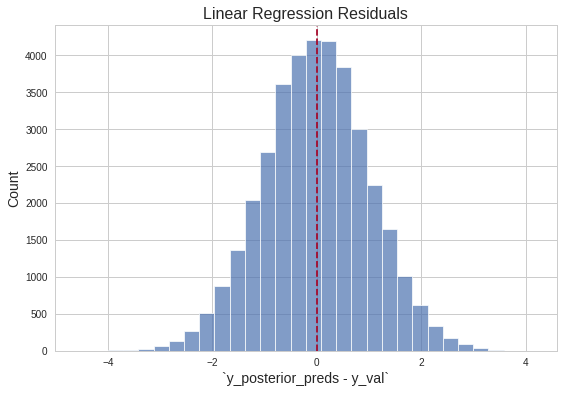

In [24]:
plot_residuals(y_posterior, X_val_feed_dict, title='Linear Regression Residuals')

"The residuals appear normally distributed with mean 0: this is a good sanity check for the model."<sup>1</sup> However, with respect to the magnitude of the mean of the validation `logerror`, our validation score is terrible. This is likely due to the fact that three predictors are not nearly sufficient for capturing the variation in the response. (Additionally, because the response itself is an *error*, it should be fundamentally harder to capture than the thing actually being predicted — the house price. This is because Zillow's team has already built models to capture this signal, then effectively threw the remaining "uncaptured" signal into this competition, i.e. "figure out how to get right the little that we got wrong.")

#### Inspect parameter posteriors

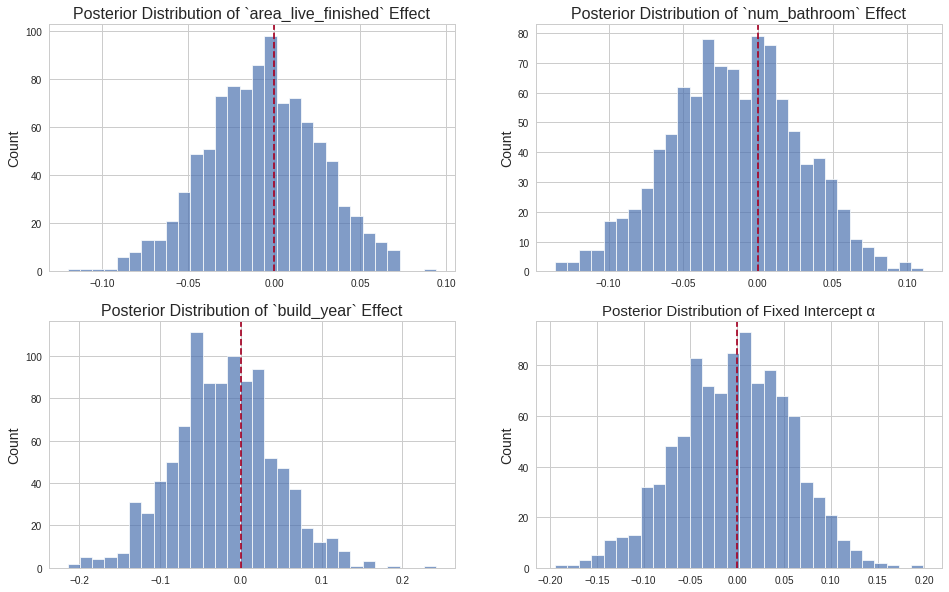

In [25]:
# draw samples from posteriors
qβ_fixed_effects_samples = qβ_fixed_effects.sample(1000).eval()
qα_samples = qα.sample(1000).eval()

# plot samples
plt.figure(figsize=(16, 10))

for dimension in range(D):
    subplot = plt.subplot(221 + dimension)
    plt.hist(qβ_fixed_effects_samples[:, dimension], edgecolor='white', linewidth=1, bins=30, alpha=.7)
    plt.axvline(0, color='#A60628', linestyle='--')
    title = f'Posterior Distribution of `{fixed_effect_predictors[dimension]}` Effect'
    plt.ylabel('Count', fontsize=14)
    plt.title(title, fontsize=16)
    
subplot = plt.subplot(221 + dimension + 1)
plt.hist(qα_samples, edgecolor='white', linewidth=1, bins=30, alpha=.7)
plt.axvline(0, color='#A60628', linestyle='--')
title = f'Posterior Distribution of Fixed Intercept α'
plt.ylabel('Count', fontsize=14)
plt.title(title, fontsize=15)

In keeping with the definition of multivariate linear regression itself, the above parameter posteriors tell us: "conditional on the assumption that the log-error and fixed effects can be related by a straight line, what is the predictive value of one variable once I already know the values of all other variables?"<sup>2</sup>

## Bayesian linear regression with random effects
Random effects models — also known as hierarchical models — allow us to ascribe distinct behaviors to different "clusters" of observations, i.e. groups that may each act in a materially unique way. Furthermore, these models allow us to infer these tendencies in a *collaborative* fashion: while each cluster is assumed to behave differently, it can learn its parameters by heeding to the behavior of the population at large. In this example, we assume that houses in different zipcodes — holding all other predictors constant — should be priced in different ways.

For clarity, let's consider the two surrounding extremes:
1. Estimate a single set of parameters for the population, i.e. the vanilla, [scikit-learn linear regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), Bayesian or not. This confers no distinct behaviors to houses in different zipcodes.
2. Estimate a set of parameters for each individual zipcode, i.e. split the data into its cluster groups and estimate a single model for each. This confers maximally distinct behaviors to houses in different zip codes: the behavior of one cluster knows nothing about that of the others.

Random-effects models "walk the line" between these two approaches — between maximally *underfitting* and maximally *overfitting* the behavior of each cluster. To this effect, its parameter estimates exhibit the canonical "shrinkage" phenomenon: the estimate for a given parameter is balanced between the within-cluster expectation and the global expectation. Smaller clusters exhibit larger shrinkage; larger clusters, i.e. those for which we've observed more data, are more bullheaded (in typical Bayesian fashion). A later plot illustrates this point.

We specify our random-effects functional form as follows:

``` python
μ_y = α + α_random_effects + ed.dot(fixed_effects, β_fixed_effects)
y = Normal(loc=μ_y, scale=tf.ones(N))
```

With respect to the previous model, we've simply added `α_random_effects` to the mean of our response. As such, this is a *varying-intercepts* model: the intercept term will be different for each cluster. To this end, we learn the *global* intercept `α` as well as the *offsets* from this intercept `α_random_effects` — a random variable with as many dimensions as there are zipcodes. In keeping with the notion of "offset," we ascribe it a prior of `(0, σ_zc)`. This approach allows us to flexibly extend the model to include more random effects, e.g. city, architecture style, etc. With only one, however, we could have equivalently included the global intercept *inside* of our prior, i.e. `α_random_effects ~ Normal(α, σ_zc)`, with priors on both `α` and `σ_zc` as per usual. This way, our random effect would no longer be a zip-code-specific *offset* from the global intercept, but a vector of zip-code-specific intercepts outright.

Finally, as Richard McElreath notes, "we can think of the `σ_zc` parameter for each cluster as a crude measure of that cluster's "relevance" in explaining variation in the response variable."<sup>3</sup>

### Fit model

In [26]:
n_zip_codes = len(set(zip_codes))

# random-effect placeholder
zip_codes_ph = tf.placeholder(tf.int32, [N])

# random-effect parameter
σ_zip_code = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
α_zip_code = Normal(loc=tf.zeros(n_zip_codes), scale=σ_zip_code * tf.ones(n_zip_codes))
    
# model
α_random_effects = tf.gather(α_zip_code, zip_codes_ph)
μ_y = α + α_random_effects + ed.dot(fixed_effects, β_fixed_effects)
y = Normal(loc=μ_y, scale=tf.ones(N))

# approximate random-effect distribution
qα_zip_code = Normal(
    loc=tf.Variable(tf.random_normal([n_zip_codes])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_zip_codes])))
)

### Infer parameters

In [27]:
latent_vars = {
    β_fixed_effects: qβ_fixed_effects,
    α: qα,
    α_zip_code: qα_zip_code
}

sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={fixed_effects: X_train, zip_codes_ph: zip_codes[train_index], y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 34747.445


### Criticize model

In [28]:
param_posteriors = {
    β_fixed_effects: qβ_fixed_effects.mean(),
    α: qα.mean(),
    α_zip_code: qα_zip_code.mean()
}
X_val_feed_dict = {
    fixed_effects: X_val,
    zip_codes_ph: zip_codes[val_index]
}
y_posterior = ed.copy(y, param_posteriors)

In [29]:
compute_mean_absolute_error(y_posterior, X_val_feed_dict)

Mean absolute error on validation data: 0.081983


#### Inspect residuals

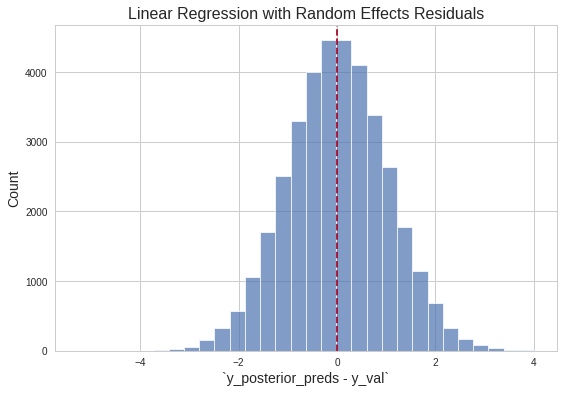

In [30]:
plot_residuals(y_posterior, X_val_feed_dict, title='Linear Regression with Random Effects Residuals')

### Plot shrinkage
To illustrate shrinkage we'll pare our model down to intercepts only (removing the fixed effects entirely). We'll first fit a random-effects model on the full dataset then compute the cluster-specific-intercept posterior means. Next, we'll fit a separate model to each individual cluster and compute the intercept posterior mean of each. The plot below shows how estimates from the former can be viewed as "estimates from the latter — shrunk towards the global-intercept posterior mean."

Finally, <span style="color: #377eb8">blue</span>, <span style="color: #4daf4a">green</span> and <span style="color: #ff7f00">orange</span> points represent small, medium and large clusters respectively. As mentioned before, the larger the cluster size, i.e. the more data points we've observed belonging to a given cluster, the *less* prone it is to shrinkage towards the mean.

#### Estimate random-effects intercepts

In [31]:
# model
μ_y = α + α_random_effects
y = Normal(loc=μ_y, scale=tf.ones(N))

latent_vars = {
    α: qα,
    α_zip_code: qα_zip_code
}

# infer parameters
sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={zip_codes_ph: zip_codes[train_index], y: y_train})
inference.run(n_samples=5, n_iter=250)

# compute global intercept posterior mean
global_intercept_posterior_mean = qα.mean().eval()

# compute random-effects posterior means
random_effects_posterior_means = global_intercept_posterior_mean + qα_zip_code.mean().eval()
random_effects_posterior_means = pd.Series(random_effects_posterior_means, index=range(0, n_zip_codes),
                                          name='random_effects_posterior_means')

250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 34587.109


#### Estimate within-cluster intercepts

In [32]:
# select a few clusters of varying size
zip_codes_df = pd.DataFrame({'cluster_size': zip_codes[train_index].value_counts()})
zip_codes_df['cluster_size_group'] = pd.cut(zip_codes_df['cluster_size'], 3, labels=['small', 'medium', 'large'])
zip_codes_df = zip_codes_df.groupby('cluster_size_group').head(20)

# build individual models for each cluster
within_cluster_posterior_means = {}

for zip_code in zip_codes_df.index.unique():
    # compute mask, number of observations
    mask = zip_codes[train_index] == zip_code
    N_ = mask.sum()
    
    # instantiate model for current cluster
    fixed_effects = tf.placeholder(tf.float32, [N_, D])
    μ_y = α
    y = Normal(loc=μ_y, scale=tf.ones(N_))
    
    # fit model
    sess.run(INIT_OP)
    inference = ed.KLqp(latent_vars, data={y: y_train[mask]})
    inference.run(n_samples=5, n_iter=250)
    
    # compute mean of qα for this zip code
    within_cluster_posterior_means[zip_code] = qα.mean().eval()[0]
    
within_cluster_posterior_means = pd.Series(within_cluster_posterior_means, name='within_cluster_posterior_means')

250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 428.182
250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 350.116
250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 342.038 1s | Loss: 342
250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 308.568
250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 278.030
250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 272.690
250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 253.256 0s | Loss: 252.
250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 239.401
250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 235.704
250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 232.208
250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 219.015
250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 213.329
250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 220.976
250/250

In [33]:
# prepare for plotting: join, give colors, sort, reset index
zip_codes_df = zip_codes_df\
    .join(within_cluster_posterior_means)\
    .join(random_effects_posterior_means)
zip_codes_df['cluster_size_color'] = zip_codes_df['cluster_size_group'].map({'small': '#377eb8', 'medium': '#4daf4a', 'large': '#ff7f00'})
zip_codes_df = zip_codes_df\
    .sort_values(by='cluster_size')\
    .reset_index(drop=True)

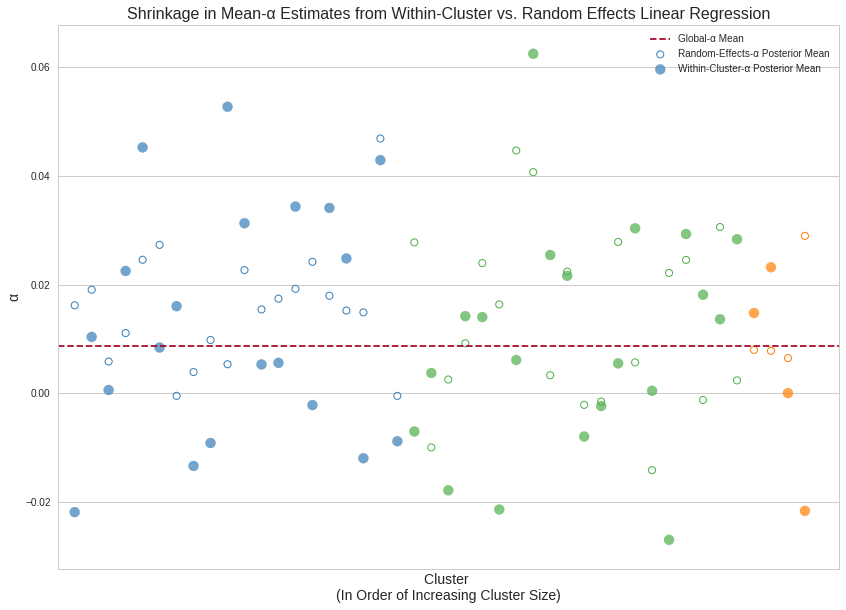

In [34]:
# plot shrinkage
plt.figure(figsize=(14, 10))
plt.xlim(-1, len(zip_codes_df) + 1)

plt.scatter(zip_codes_df.index, zip_codes_df['random_effects_posterior_means'], facecolors='none',
            edgecolors=zip_codes_df['cluster_size_color'], s=50, linewidth=1, 
            alpha=1, label='Random-Effects-α Posterior Mean')
plt.scatter(zip_codes_df.index, zip_codes_df['within_cluster_posterior_means'], c=zip_codes_df['cluster_size_color'], 
            s=100, alpha=.7, label='Within-Cluster-α Posterior Mean')
plt.axhline(global_intercept_posterior_mean, color='#A60628', linestyle='--', label='Global-α Mean')
plt.xticks([])
plt.xlabel('Cluster \n(In Order of Increasing Cluster Size)', fontsize=14)
plt.ylabel('α', fontsize=14)
plt.title('Shrinkage in Mean-α Estimates from Within-Cluster vs. Random Effects Linear Regression', fontsize=16)
plt.legend()

## Neural network with random effects
Neural networks are powerful function approximators. Keras is a library that lets us flexibly define complex neural architectures. Thus far, we've been approximating the relationship between our fixed effects and response variable with a simple dot product; can we leverage Keras to make this relationship more expressive? Is it painless? Finally, how does it integrate with Edward's existing APIs and constructs? Can we couple nimble generative models with deep neural networks?

While my experimentation was brief, all answers point delightfully towards "yes" for two simple reasons:
1. Edward and Keras both run on TensorFlow.
2. "Black-box" variational inference makes everything scale.

This said, we must be nonetheless explicit about what's "Bayesian" and what's not, i.e. for which parameters do we infer full (approximate) posterior distributions, and for which do we infer point estimates of the posterior distribution.

Below, we drop a `neural_network` in place of our dot product. Our latent variables remain `β_fixed_effects`, `α` and `α_zip_code`: while we will infer their full (approximate) posterior distributions as before, we'll only compute *point estimates* for the parameters of the neural network as in the typical case. Conversely, to the best of my knowledge, to infer full distributions for the latter, we'll need to specify our network manually in raw TensorFlow, i.e. ditch Keras entirely. We then treat our weights and biases as standard latent variables and infer their approximate posteriors via variational inference.  Edward's documentation contains a straightforward [tutorial](http://edwardlib.org/tutorials/bayesian-neural-network) to this end.

### Fit model

In [35]:
def neural_network(fixed_effects, λ=.001, input_dim=D):
    dense = Dense(5, activation='tanh', kernel_regularizer=l2(λ))(fixed_effects)
    output = Dense(1, activation='linear', name='output', kernel_regularizer=l2(λ))(dense)
    return K.squeeze(output, axis=1)

# model
fixed_effects = tf.placeholder(tf.float32, [N, D])
μ_y = α + α_random_effects + neural_network(fixed_effects)
y = Normal(loc=μ_y, scale=tf.ones(N))

In [36]:
latent_vars = {
    β_fixed_effects: qβ_fixed_effects,
    α: qα,
    α_zip_code: qα_zip_code
}

sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={fixed_effects: X_train, zip_codes_ph: zip_codes[train_index], y: y_train})
optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
inference.initialize(optimizer=optimizer)
inference.run(n_samples=5, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 13s | Loss: 34517.113


### Criticize model

In [37]:
param_posteriors = {
    β_fixed_effects: qβ_fixed_effects.mean(),
    α: qα.mean(),
    α_zip_code: qα_zip_code.mean()
}
X_val_feed_dict = {
    fixed_effects: X_val,
    zip_codes_ph: zip_codes[val_index]
}
y_posterior = ed.copy(y, param_posteriors)

In [38]:
compute_mean_absolute_error(y_posterior, X_val_feed_dict)

Mean absolute error on validation data: 0.080011


#### Inspect residuals

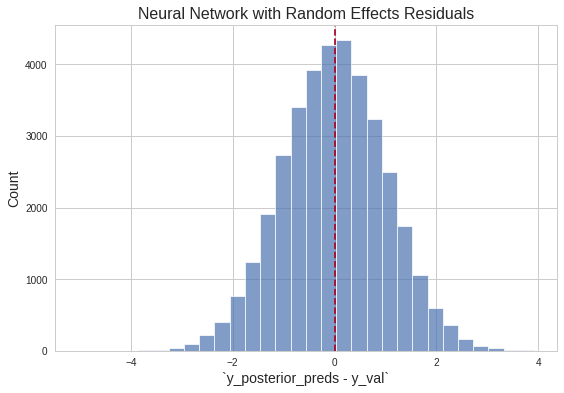

In [39]:
plot_residuals(y_posterior, X_val_feed_dict, title='Neural Network with Random Effects Residuals')

# Future work
We've now laid a stable, if trivially simple foundation for building models with Edward and Keras. From here, I see two distinct paths to building more expressive probabilistic models using these tools:
1. Build probabilistic models in Edward, and abstract deep-network-like subgraphs into Keras layers. This allows us to flexibly define complex neural architectures, e.g. a [video question answering model](https://keras.io/getting-started/functional-api-guide/#video-question-answering-model), with a nominal amount of code, yet restricts us from, or at least makes it awkward to, infer full posterior distributions for the subgraph parameters.
2. Build probabilistic models in Edward, and specify deep-network-like subgraphs with raw TensorFlow — ditching Keras entirely. Defining deep-network-like subgraphs becomes more cumbersome, while inferring full posterior distributions for the subgraph parameters becomes more natural and consistent with the flow of Edward code.

This work has shown a few basic variants of (generalized) Bayesian linear regression models. From here, there's tons more to explore — varying-slopes models, Gaussian process regression, mixture models and probabilistic matrix factorizations to name a random few. 

Edward and Keras have proven a flexible, expressive and powerful duo for performing inference in deep probabilistic models. The models we built were simple; the only direction to go, and to go rather painlessly, is more.

Many thanks for reading.

# References
1. [Edward - Linear Mixed Effects Models](http://edwardlib.org/tutorials/linear-mixed-effects-models)
2. McElreath, Richard. "Chapter 5." Statistical Rethinking: A Bayesian Course with Examples in R and Stan. Boca Raton, FL: CRC, Taylor & Francis Group, 2016. N. pag. Print.
3. McElreath, Richard. "Chapter 12." Statistical Rethinking: A Bayesian Course with Examples in R and Stan. Boca Raton, FL: CRC, Taylor & Francis Group, 2016. N. pag. Print.
4. [The Best Of Both Worlds: Hierarchical Linear Regression in PyMC3](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/)
5. [Keras as a simplified interface to TensorFlow](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html)
6. [Mixture Density Networks with Edward, Keras and TensorFlow](http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html)
7. [Use a Hierarchical Model](http://sl8r000.github.io/ab_testing_statistics/use_a_hierarchical_model/)
8. McElreath, Richard. "Chapter 14." Statistical Rethinking: A Bayesian Course with Examples in R and Stan. Boca Raton, FL: CRC, Taylor & Francis Group, 2016. N. pag. Print.